### COVID Tracking Project Enhancements to Johns Hopkins Case/Fatality Data

Like many analytics geeks, I've been tracking data on the Covid pandemic since early spring.  My main source is the [Center for Systems Science and Engineering at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series), with files for download made available at midnight Central time. I've established a pretty [significant R infrastructure in JupyterLab](https://www.datasciencecentral.com/profiles/blogs/johns-hopkins-covid-19-and-r-part-iii-world-data-1) to summarize daily developments. The combination of R data.table and tidyverse programming capabilities has made the computation straightforward. 

Much as I've been successful using the daily Hopkins data on new cases and fatalities with granularity county within state to fuel graphs and dashboards, I recently started seeking hospitalization and ICU figures as well. My hope was to relate cases and hospitalizations to predict fatalities. I was able to identify a website [COVID Tracking Project](https://covidtracking.com/data/national/hospitalization) with such hospitalization data, though my confidence was more with date-aggregated alone rather than state within date, which I initially sought. Turns out COVID hospitalization data summarized by date is much better behaved than the more granular with state added, so I made a concession.

The code that follows first scrapes and munges daily hospitalization data from COVID Tracking website, then reads a previously built data.table from the Johns Hopkins Covid data portal, ultimately joining the two on date. I next embellish the data with several covariates and set about to forecasting. 

The modeling challenges the combined data purports to address involve predicting fatalities as a function of cases and hospitalizations lagged in time. And the model I investigate is akin to those based on "theories" I've seen in the news: fatalities(t) = fnct(cases(t-21) + hospitalizations(t-14) + ICU(t-7)). In this instance, the explanatory attributes are considered distributed lag [(DL)](https://www.mathworks.com/help/econ/time-series-regression-viii-lagged-variables-and-estimator-bias.html;jsessionid=8e237585ae4c88ada0da4c87c500) for which the predictors are all exogenous. Now one could reasonably argue that both hospitalizations and ICU should be considered endogenous to cases, but I won't address that here, my intention being to simply show the data integration and modeling steps. I also do not mine the data to find optimal lag levels, wary of overfitting (which, alas, is happening regardless). I simply fit one specification for each modeling function.

In the end, I consider two R functions here: the first, linear models with standby lm, the second, gradient boosting from the xgboost package. The precise model specification for both lm and xgboost is fatalities(t) = dayofweek(t) + aftermay(t) + cases(t-21) + hospitalizations(t-14) + ICU(t-7). After each model is fit, I then forecast next week fatalities with both models, settling finally on an average of the two predictions ensemble.

What I hope readers take away from this is the thinking behind building multiple data.tables from web downloads/scrapings, combining the data via join/merge functions, then finally starting the exploration and modeling processes. 

The software used below is JupyterLab 2.1.2 and R 4.0.2. R's splendid tidyverse and data.table packages are featured for data analysis, while lm and xgboost are used for modeling.


Confirm current R library folders.

In [66]:
.libPaths()

[1] "C:/R/4.0.2/library"                 "C:/Program Files/R/R-4.0.2/library"

Load libraries and include personal functions.

In [67]:
options(warn=-1) 
options(scipen = 20)
options(datatable.print.topn=100)
options(datatable.showProgress=FALSE)

usualsuspects <- c(
    'tidyverse', 'data.table', 'pryr', 'plyr','readxl', 'bit', 'grid', 'gridExtra',     
    'rvest', 'magrittr','lubridate','rlist', 'tictoc', 'skimr','pracma','TTR',
    'fst','feather','rio', 'Rcpp','tidyquant', 'Matrix', 'arrow',
    'knitr', 'kableExtra', 'microbenchmark', "Metrics",
    'ggplot2','RColorBrewer',
    'magick',"webshot","IRdisplay",    
    'incidence','outbreaks','EpiEstim', 'modeltime', 
    'forecast', 'timetk', 'h2o','xgboost', 'catboost', 'lightgbm'
) 

suppressMessages(invisible(lapply(usualsuspects, library, character.only = TRUE)))

funcsdir <- "/steve/r/functions"
funcsfile <- "rfunctions.r"

setwd(funcsdir)
source(funcsfile)

cppdir <- "c:/steve/c++/rstudio"
setwd(cppdir)

blanks(1)
lsf.str()

set.seed(543)

blanks(2)

allfreqs : function (dtn, catlim = 100)  
blanks : function (howmany)  
colsize : function (dt)  
diffna : function (var)  
dtmeta : function (df)  
freadfac : function (var)  
freqsdt : function (DTstr, xstr, percent = TRUE)  
fstrddt : function (var)  
meancov : function (var)  
meanna : function (var)  
meta : function (df, data = FALSE, dict = TRUE)  
mksumfreq : function (freqalldt)  
mksumfreq2 : function (dt)  
movavg : function (var, lags)  
mykab : function (dt)  
obj_sz : function (obj)  
prhead : function (df, howmany = 6)  
prheadtail : function (df, howmany = 6)  
prodna : function (var)  
sumna : function (var)  
wkday : function (dt)  

Define type-saving functions for the lazy analyst.

In [68]:
diffna <- function (var) c(NA,diff(var))
prodna <- function (var) prod(var,na.rm=TRUE)
sumna <- function (var) sum(var,na.rm=TRUE)
meanna <- function (var) round(mean(var,na.rm=TRUE))
freadfac <- function (var) data.table::fread(var,stringsAsFactors=TRUE)
fstrddt <- function(var) fst::read_fst(var,as.data.table=TRUE)
movavg <- function (var, lags) round(data.table::frollmean(var,lags))
meancov <- function(var) round(mean(var))
wkday <- function(dt) lubridate::wday(dt,label=TRUE)

blanks(2)

Scrape CovidTracking hospitalization data using the tidyverse rvest library.

In [69]:
url <- "https://covidtracking.com/data/national/hospitalization"
css <- "td"

html <- (read_html(url) %>% html_nodes(css) %>% html_text())

head(html,20)

blanks(2)

[1] "DateDec 10, 2020"                              
 [2] "Currently hospitalized/Now hospitalized107,258"
 [3] "Currently in ICU/Now in ICU21,023"             
 [4] "Currently on ventilator/Now on ventilator7,442"
 [5] "DateDec 9, 2020"                               
 [6] "Currently hospitalized/Now hospitalized106,705"
 [7] "Currently in ICU/Now in ICU20,906"             
 [8] "Currently on ventilator/Now on ventilator7,624"
 [9] "DateDec 8, 2020"                               
[10] "Currently hospitalized/Now hospitalized104,590"
[11] "Currently in ICU/Now in ICU20,483"             
[12] "Currently on ventilator/Now on ventilator7,245"
[13] "DateDec 7, 2020"                               
[14] "Currently hospitalized/Now hospitalized102,148"
[15] "Currently in ICU/Now in ICU20,098"             
[16] "Currently on ventilator/Now on ventilator7,073"
[17] "DateDec 6, 2020"                               
[18] "Currently hospitalized/Now hospitalized101,501"
[19] "Currently in ICU/Now in ICU20,145"             
[20] "Currently on ventilator/Now on ventilator7,095"

Wrangle said data with tidyverse chaining to produce a data.table suitable for downstream processing.

In [70]:
html <- html %>% gsub("Currently on ventilator/Now on ventilator","",.) %>% gsub("Currently in ICU/Now in ICU","",.) %>%  
            gsub("Currently hospitalized/Now hospitalized","",.)  %>% gsub("Date","",.)
dt <- data.table(matrix(html,ncol=4,byrow=TRUE)) %>% setnames(.,c("date","hospitalized","ICU",'ventilator'))

meta(dt)
blanks(1)
mykab(head(dt))

blanks(2)



|name|class                 |rows|columns|size    |
|:---|:---------------------|:---|:------|:-------|
|dt  |data.table, data.frame|324 |4      |74.14 KB|

Classes 'data.table' and 'data.frame':	324 obs. of  4 variables:
 $ date        : chr  "Dec 10, 2020" "Dec 9, 2020" "Dec 8, 2020" "Dec 7, 2020" ...
 $ hospitalized: chr  "107,258" "106,705" "104,590" "102,148" ...
 $ ICU         : chr  "21,023" "20,906" "20,483" "20,098" ...
 $ ventilator  : chr  "7,442" "7,624" "7,245" "7,073" ...
 - attr(*, ".internal.selfref")=<externalptr> 
NULL





|date        |hospitalized|ICU   |ventilator|
|:-----------|:-----------|:-----|:---------|
|Dec 10, 2020|107,258     |21,023|7,442     |
|Dec 9, 2020 |106,705     |20,906|7,624     |
|Dec 8, 2020 |104,590     |20,483|7,245     |
|Dec 7, 2020 |102,148     |20,098|7,073     |
|Dec 6, 2020 |101,501     |20,145|7,095     |
|Dec 5, 2020 |101,192     |19,947|7,006     |

Transform character data to numeric with data.table chaining.

In [71]:
invisible(dt[,c("date","hospitalized","ICU","ventilator"):=.(mdy(date),gsub(",","",hospitalized),gsub(",","",ICU),gsub(",","",ventilator))][,
            hospitalized:=ifelse(hospitalized=="N/A",NA,as.integer(hospitalized))][,ICU:=ifelse(ICU=="N/A",NA,as.integer(ICU))][,
            ventilator:=ifelse(ventilator=="N/A",NA,as.integer(ventilator))])
dt <- dt[order(date)]

setkey(dt,date)

meta(dt)
blanks(1)
prheadtail(dt,howmany=10)


blanks(2)



|name|class                 |rows|columns|size   |
|:---|:---------------------|:---|:------|:------|
|dt  |data.table, data.frame|324 |4      |8.04 KB|

Classes 'data.table' and 'data.frame':	324 obs. of  4 variables:
 $ date        : Date, format: "2020-01-22" "2020-01-23" ...
 $ hospitalized: int  NA NA NA NA NA NA NA NA NA NA ...
 $ ICU         : int  NA NA NA NA NA NA NA NA NA NA ...
 $ ventilator  : int  NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "date"
NULL

          date hospitalized ICU ventilator
 1: 2020-01-22           NA  NA         NA
 2: 2020-01-23           NA  NA         NA
 3: 2020-01-24           NA  NA         NA
 4: 2020-01-25           NA  NA         NA
 5: 2020-01-26           NA  NA         NA
 6: 2020-01-27           NA  NA         NA
 7: 2020-01-28           NA  NA         NA
 8: 2020-01-29           NA  NA         NA
 9: 2020-01-30           NA  NA         NA
10: 2020-01-31           NA  NA   

Save the finished table to an fst file.

In [72]:
wdir <- "/data/covidtracking"
setwd(wdir)

fname <- "hospitalizations.fst"
write_fst(dt,fname)

blanks(2)

Starting date with all hospitalization attributes non-missing.

In [73]:
prheadtail(dt[date>"2020-03-25"])

blanks(2)

         date hospitalized  ICU ventilator
1: 2020-03-26         7805 1299        258
2: 2020-03-27        10978 1792        324
3: 2020-03-28        12409 2174        390
4: 2020-03-29        14055 2456        439
5: 2020-03-30        15917 3087        451
6: 2020-03-31        18155 3487        507

         date hospitalized   ICU ventilator
1: 2020-12-05       101192 19947       7006
2: 2020-12-06       101501 20145       7095
3: 2020-12-07       102148 20098       7073
4: 2020-12-08       104590 20483       7245
5: 2020-12-09       106705 20906       7624
6: 2020-12-10       107258 21023       7442


 


Load the saved John Hopkins case/fatality data.

In [74]:
wd <- "c:/steve/covid/magrsave"
setwd(wd)

fname <- tail(list.files( pattern = "mfinal*"),1)
print(fname)
mfinalus <- import(fname,setclass="data.table")

meta(mfinalus)

print(max(mfinalus$date))

blanks(2)

[1] "mfinal-2020-12-10.fst"


|name    |class                 |rows   |columns|size   |
|:-------|:---------------------|:------|:------|:------|
|mfinalus|data.table, data.frame|1082160|17     |87.1 MB|

Classes 'data.table' and 'data.frame':	1082160 obs. of  17 variables:
 $ uid           : int  84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 ...
 $ iso2          : Factor w/ 6 levels "AS","GU","MP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ iso3          : Factor w/ 6 levels "ASM","GUM","MNP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ code3         : int  840 840 840 840 840 840 840 840 840 840 ...
 $ fips          : num  45001 45001 45001 45001 45001 ...
 $ admin2        : Factor w/ 1979 levels "","Abbeville",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ state         : Factor w/ 58 levels "Alabama","Alaska",..: 47 47 47 47 47 47 47 47 47 47 ...
 $ country_region: Factor w/ 1 level "US": 1 1 1 1 1 1 1 1 1 1 ...
 $ lat           : num  34.2 34.2 34.2 34.2 34.2 ...
 $ long_        

Demonstrate the need for a few "covariates" to aid in forecasting. The first shows variation in cases/fatalities by day of the week. This is simply a reporting artifact.

In [75]:
mykab(mfinalus[,.(daycases=sumna(daycases),daydeaths=sumna(daydeaths)),.(date)][
    ,.(.N,daycases=sumna(daycases),daydeaths=sumna(daydeaths)),.(wkday(date))][
    ,`:=`(pctcases=round(100*daycases/sum(daycases),2),pctdeaths=round(100*daydeaths/sum(daydeaths),2))])

blanks(2)



|wkday|N  |daycases|daydeaths|pctcases|pctdeaths|
|:----|:--|:-------|:--------|:-------|:--------|
|Wed  |47 |2341399 |54395    |15.00   |18.62    |
|Thu  |47 |2462133 |49380    |15.77   |16.90    |
|Fri  |46 |2453703 |45750    |15.72   |15.66    |
|Sat  |46 |2216702 |38970    |14.20   |13.34    |
|Sun  |46 |1880141 |24106    |12.04   |8.25     |
|Mon  |46 |2010159 |28302    |12.88   |9.69     |
|Tue  |46 |2246776 |51238    |14.39   |17.54    |

This one shows the difference in the case mortality rate before and after the last day in May.

In [76]:
mykab(mfinalus[,.(daycases=sumna(daycases),daydeaths=sumna(daydeaths)),.(aftermay=date>"2020-05-31")][
    ,.(aftermay,fatalrate=round(100*(daydeaths/daycases),2))])

blanks(2)



|aftermay|fatalrate|
|:-------|:--------|
|FALSE   |6.00     |
|TRUE    |1.34     |

Now join the case/fatality and hospitalization/ICU data.tables, adding dayofweek and aftermay covariates.

In [77]:
covidjhu <- mfinalus[,.(daycases=sumna(daycases),daydeaths=sumna(daydeaths)),.(date)]
covidfinal <- dt[covidjhu][,dayofweek:=wkday(date)][,aftermay:=date>"2020-05-31"][,idx:=.N:1]

meta(covidfinal)
blanks(1)
prheadtail(covidfinal) 

blanks(2)



|name      |class                 |rows|columns|size    |
|:---------|:---------------------|:---|:------|:-------|
|covidfinal|data.table, data.frame|324 |9      |15.92 KB|

Classes 'data.table' and 'data.frame':	324 obs. of  9 variables:
 $ date        : Date, format: "2020-01-22" "2020-01-23" ...
 $ hospitalized: int  NA NA NA NA NA NA NA NA NA NA ...
 $ ICU         : int  NA NA NA NA NA NA NA NA NA NA ...
 $ ventilator  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ daycases    : int  0 0 1 0 3 0 0 1 0 2 ...
 $ daydeaths   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dayofweek   : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tue"<..: 4 5 6 7 1 2 3 4 5 6 ...
 $ aftermay    : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ idx         : int  324 323 322 321 320 319 318 317 316 315 ...
 - attr(*, "sorted")= chr "date"
 - attr(*, ".internal.selfref")=<externalptr> 
NULL

         date hospitalized ICU ventilator daycases daydeaths dayofweek aftermay
1: 2020-01-22           NA  NA         NA        0      

Save the joined data in fst, feather, and parquet formats.

In [78]:
wdir <- "/data/covidtracking"
setwd(wdir)


fname <- "coviddaily.fst"
write_fst(covidfinal,fname)

fname <- "coviddaily.feather"
write_feather(covidfinal,fname)

fname <- "coviddaily.parquet"
write_parquet(covidfinal,fname)

blanks(2)

Build the data.table to be used for forecasting.

In [79]:
ncovidfinal <- covidfinal[date>"2020-03-25"][,c("daycases_lag21","hospitalized_lag14","ICU_lag7")
                          :=.(shift(daycases, 21L, fill = NA, type = "lag"),
                             shift(hospitalized, 14L, fill = NA, type = "lag"),
                             shift(ICU, 7L, fill = NA, type = "lag"))]

nr <- nrow(ncovidfinal)
meta(ncovidfinal)

blanks(2)



|name       |class                 |rows|columns|size    |
|:----------|:---------------------|:---|:------|:-------|
|ncovidfinal|data.table, data.frame|260 |12     |16.81 KB|

Classes 'data.table' and 'data.frame':	260 obs. of  12 variables:
 $ date              : Date, format: "2020-03-26" "2020-03-27" ...
 $ hospitalized      : int  7805 10978 12409 14055 15917 18155 20906 22997 25777 30268 ...
 $ ICU               : int  1299 1792 2174 2456 3087 3487 3937 4513 4928 5500 ...
 $ ventilator        : int  258 324 390 439 451 507 561 574 623 656 ...
 $ daycases          : int  17840 18680 19607 18879 22082 26316 25883 30387 31970 33015 ...
 $ daydeaths         : int  412 518 633 592 696 1092 1180 1503 1393 1541 ...
 $ dayofweek         : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tue"<..: 5 6 7 1 2 3 4 5 6 7 ...
 $ aftermay          : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ idx               : int  260 259 258 257 256 255 254 253 252 251 ...
 $ daycases_lag21    : int  NA NA NA NA 

A few visuals showing how the pandemic behaved differently before and after the end of May.

`geom_smooth()` using formula 'y ~ x'



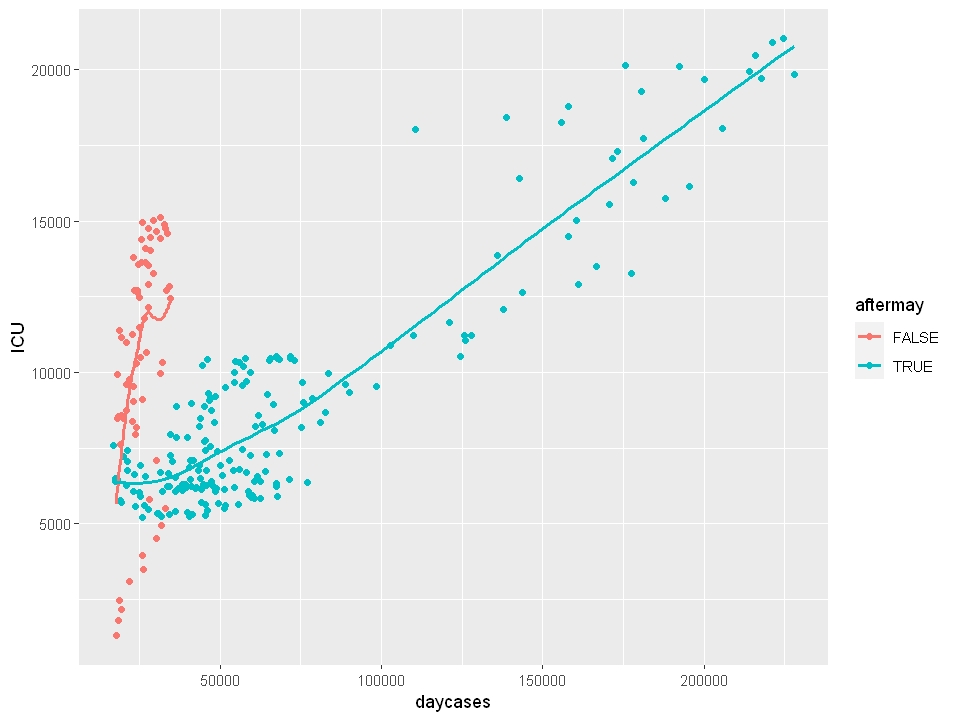

In [80]:
ggplot(ncovidfinal,aes(x=daycases,y=ICU, color=aftermay)) + geom_point() + geom_smooth(method='loess', se=FALSE)

`geom_smooth()` using formula 'y ~ x'



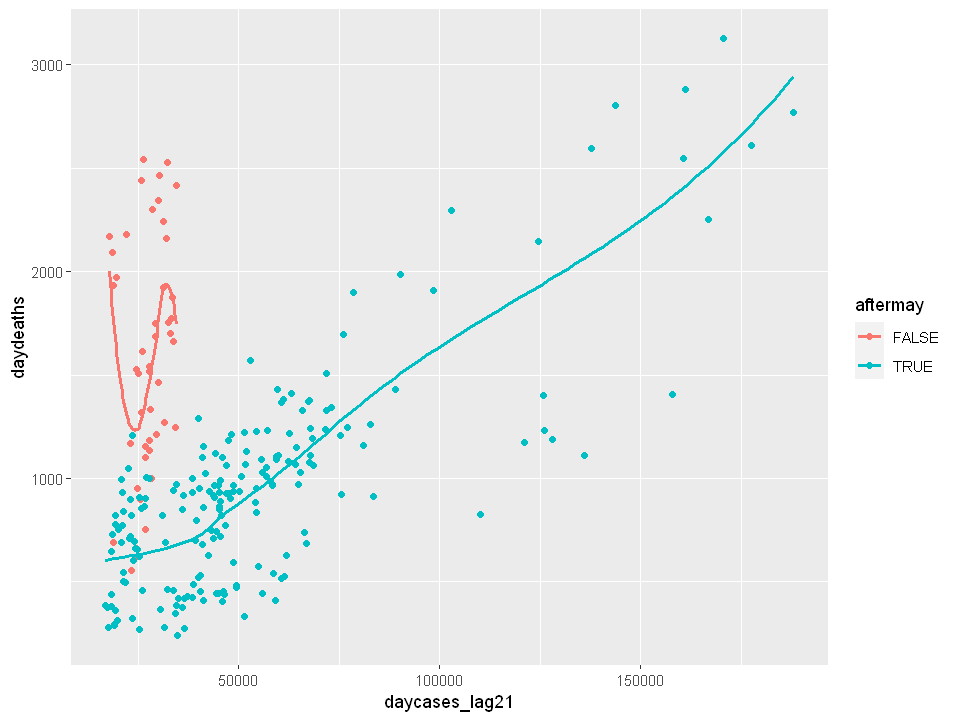

In [81]:
ggplot(ncovidfinal[22:nr],aes(x=daycases_lag21,y=daydeaths,color=aftermay)) + geom_point() + geom_smooth(method='loess', se=FALSE)

`geom_smooth()` using formula 'y ~ x'



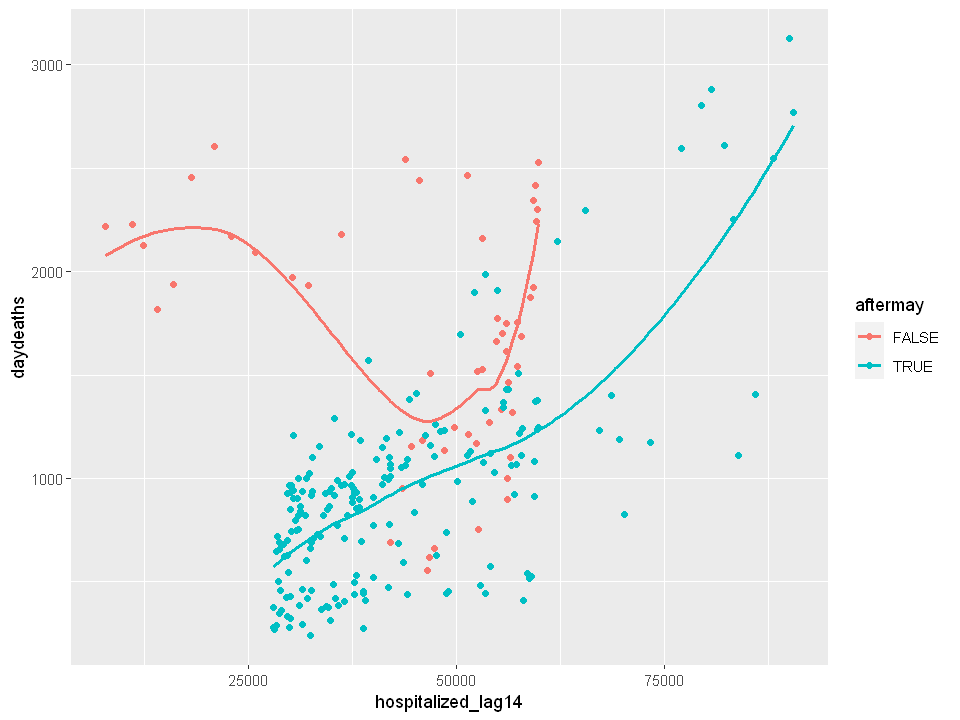

In [82]:
ggplot(ncovidfinal[15:nr],aes(x=hospitalized_lag14,y=daydeaths,color=aftermay)) + geom_point() + geom_smooth(method='loess', se=FALSE)

`geom_smooth()` using formula 'y ~ x'



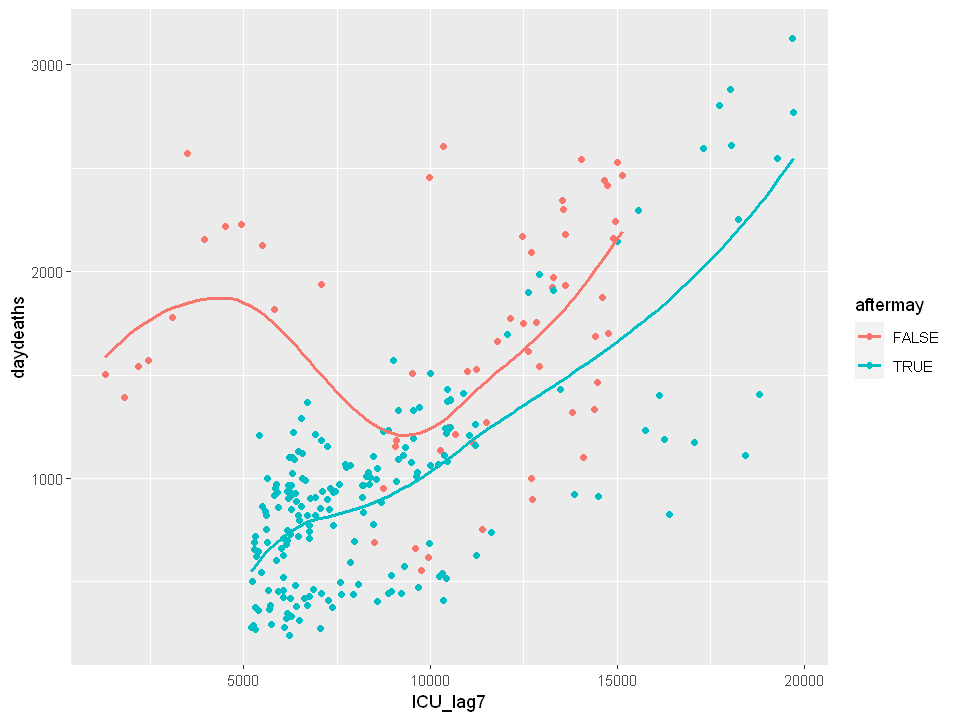

In [83]:
ggplot(ncovidfinal,aes(x=ICU_lag7,y=daydeaths,color=aftermay)) + geom_point() + geom_smooth(method='loess', se=FALSE)

Now set up two models, a linear and a gradient boosting, to forecast a coming week of Covid fatalities.

In [84]:
depvar <- c("daydeaths")
indvars <- c("aftermay","dayofweek","daycases_lag21","hospitalized_lag14","ICU_lag7")
vars <- c(depvar,indvars)

blanks(2)

First, fit and examine a linear model. Note that ICU_lag7 is highly significant and appears to crowd out hospitalized_lag14 and daycases_lag21. We'll stick with the full model though.

In [85]:
lst <- lm(as.formula(paste(depvar,"~",paste(indvars,collapse="+"),sep="")),data=ncovidfinal[22:nr,..vars])

summary(lst)

blanks(2)


Call:
lm(formula = as.formula(paste(depvar, "~", paste(indvars, collapse = "+"), 
    sep = "")), data = ncovidfinal[22:nr, ..vars])

Residuals:
    Min      1Q  Median      3Q     Max 
-864.05 -124.11   -2.16  113.33  870.44 

Coefficients:
                      Estimate  Std. Error t value             Pr(>|t|)    
(Intercept)         439.301265  132.627095   3.312             0.001076 ** 
aftermayTRUE       -324.440283   86.547209  -3.749             0.000225 ***
dayofweek.L         392.610043   41.562417   9.446 < 0.0000000000000002 ***
dayofweek.Q        -558.583804   39.780136 -14.042 < 0.0000000000000002 ***
dayofweek.C           0.062361   40.015107   0.002             0.998758    
dayofweek^4         188.559054   39.740012   4.745          0.000003683 ***
dayofweek^5        -210.585763   39.573298  -5.321          0.000000246 ***
dayofweek^6          21.950965   39.613672   0.554             0.580036    
daycases_lag21        0.003030    0.001368   2.216             0.027714 *

In [86]:
v <- var(ncovidfinal[22:nr]$daydeaths)
m <- mse(ncovidfinal[22:nr]$daydeaths,predict(lst))
r2 <- 1-m/v

v
m
r2

blanks(2)

[1] 342717.5

[1] 51065.54

[1] 0.8509982

Next, gradient boosting from xgboost. First, though, create a model matrix from the analysis data.table.

In [87]:
trainspm <- xgb.DMatrix(sparse.model.matrix(as.formula(paste0(depvar,"~.")), data = ncovidfinal[22:nr,..vars]), label =  ncovidfinal[22:nr][[depvar]])

str(trainspm)

bst <- xgb.train(data = trainspm, max_depth = 6, eta = .3, nthread = 2, nrounds = 10, subsample = .3, tree_method="exact",
              gamma=5,verbose=1, subsample=.5,lambda=2,alpha=2,objective = "reg:squarederror",eval_metric = "rmse")

blanks(2)

Class 'xgb.DMatrix' <externalptr> 
 - attr(*, ".Dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:11] "(Intercept)" "aftermayTRUE" "dayofweek.L" "dayofweek.Q" ...

 


Look at the results. ICU_lag7 is by far the most important "regressor".

In [88]:
v <- var(ncovidfinal[22:nr]$daydeaths)
m <- mse(ncovidfinal[22:nr]$daydeaths,predict(bst,newdata=trainspm))
r2 <- 1-m/v

v
m
r2

blanks(2)

[1] 342717.5

[1] 29308.62

[1] 0.9144817

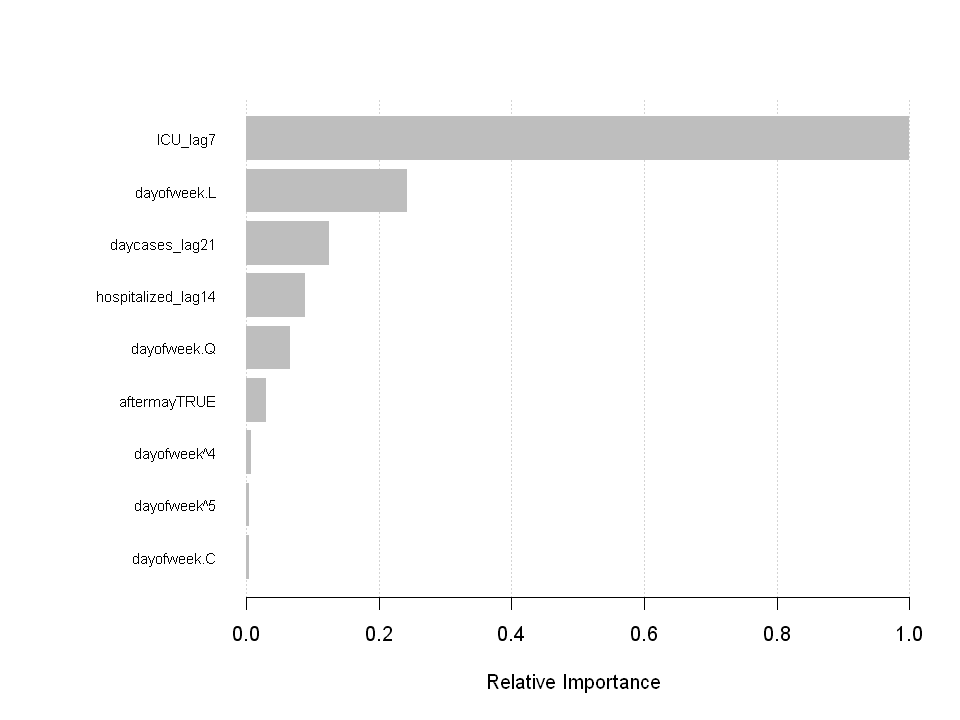

In [89]:
options(repr.plot.width=8, repr.plot.height=6)

importance <- xgb.importance(feature_names = colnames(trainspm), model = bst)
xgb.plot.importance(importance, rel_to_first = TRUE, xlab = "Relative Importance")

blanks(2)

Build the "newdata" data.table used for forecasting the next week.

In [90]:
newdt <- data.table(date=ncovidfinal[idx==1]$date+1:7,
                    aftermay=rep(TRUE,7),
                    dayofweek=ncovidfinal[between(idx,1,7),dayofweek],
                    daycases_lag21=ncovidfinal[between(idx,15,21),daycases],
                    hospitalized_lag14=ncovidfinal[between(idx,8,14),hospitalized], 
                    ICU_lag7=ncovidfinal[between(idx,1,7),ICU]                                       
                   )
meta(newdt)
blanks(1)
mykab(newdt)

blanks(2)



|name |class                 |rows|columns|size   |
|:----|:---------------------|:---|:------|:------|
|newdt|data.table, data.frame|7   |6      |2.87 KB|

Classes 'data.table' and 'data.frame':	7 obs. of  6 variables:
 $ date              : Date, format: "2020-12-11" "2020-12-12" ...
 $ aftermay          : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ dayofweek         : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tue"<..: 6 7 1 2 3 4 5
 $ daycases_lag21    : int  195518 178097 142807 171515 172988 181287 110654
 $ hospitalized_lag14: int  89950 91762 93357 96149 98777 100322 100755
 $ ICU_lag7          : int  19858 19947 20145 20098 20483 20906 21023
 - attr(*, ".internal.selfref")=<externalptr> 
NULL





|date      |aftermay|dayofweek|daycases_lag21|hospitalized_lag14|ICU_lag7|
|:---------|:-------|:--------|:-------------|:-----------------|:-------|
|2020-12-11|TRUE    |Fri      |195518        |89950             |19858   |
|2020-12-12|TRUE    |Sat      |178097        |91762             |19947   |
|2020-12-13|TRUE    |Sun      |142807        |93357             |20145   |
|2020-12-14|TRUE    |Mon      |171515        |96149             |20098   |
|2020-12-15|TRUE    |Tue      |172988        |98777             |20483   |
|2020-12-16|TRUE    |Wed      |181287        |100322            |20906   |
|2020-12-17|TRUE    |Thu      |110654        |100755            |21023   |

Also create the model matrix for xgboost.

In [91]:
newspm <- xgb.DMatrix(sparse.model.matrix(as.formula(paste0("~.")), data = newdt[,..indvars]))

dimnames(newspm)

blanks(2)

[[1]]
NULL

[[2]]
 [1] "(Intercept)"        "aftermayTRUE"       "dayofweek.L"       
 [4] "dayofweek.Q"        "dayofweek.C"        "dayofweek^4"       
 [7] "dayofweek^5"        "dayofweek^6"        "daycases_lag21"    
[10] "hospitalized_lag14" "ICU_lag7"

Separate lm, xgboost, and combined next week predictions. Big differences in lm and xgboost forecasts, which I'm currently examining.  For now, use the average of the two -- which still appears to lowball forecasts.

In [92]:
print(round(predict(lst,newdata=newdt)))
print(sum(round(predict(lst,newdata=newdt))))
blanks(1)
print(round(predict(bst,newdata=newspm)))
print(sum(round(predict(bst,newdata=newspm))))
blanks(1)
print(round((predict(lst,newdata=newdt)+predict(bst,newdata=newspm))/2))
print(sum(round((predict(lst,newdata=newdt)+predict(bst,newdata=newspm))/2)))

blanks(2)

   1    2    3    4    5    6    7 
2482 2238 1742 1909 2539 2673 2317 
[1] 15900

[1] 2134 1807 1369 1520 2359 2472 2003
[1] 13664

   1    2    3    4    5    6    7 
2308 2022 1556 1714 2449 2572 2160 
[1] 14781

 


Construct a data.table with the last week of actuals along with next week's forecasts.

In [93]:
vars = c("aftermay","dayofweek","daycases_lag21","hospitalized_lag14","ICU_lag7","daydeaths")
vars <- c("date",vars)

blanks(2)

In [94]:
newdtt <- rbind(tail(ncovidfinal[,..vars],7),
    cbind(newdt,predicted=round((predict(lst,newdata=newdt)+predict(bst,newdata=newspm))/2)) 
              ,use.names=F)

mykab(newdtt)

blanks(2)



|date      |aftermay|dayofweek|daycases_lag21|hospitalized_lag14|ICU_lag7|daydeaths|
|:---------|:-------|:--------|:-------------|:-----------------|:-------|:--------|
|2020-12-04|TRUE    |Fri      |177568        |82279             |18061   |2607     |
|2020-12-05|TRUE    |Sat      |166750        |83346             |18249   |2254     |
|2020-12-06|TRUE    |Sun      |135941        |83882             |18437   |1113     |
|2020-12-07|TRUE    |Mon      |157820        |85979             |18801   |1404     |
|2020-12-08|TRUE    |Tue      |160574        |88174             |19295   |2546     |
|2020-12-09|TRUE    |Wed      |170513        |90041             |19680   |3124     |
|2020-12-10|TRUE    |Thu      |188033        |90564             |19723   |2768     |
|2020-12-11|TRUE    |Fri      |195518        |89950             |19858   |2308     |
|2020-12-12|TRUE    |Sat      |178097        |91762             |19947   |2022     |
|2020-12-13|TRUE    |Sun      |142807        |93357            

Display forecasts along with most recent actuals in html using R's knitr library.

In [95]:
wd <- "c:/steve/covid/modeling"
setwd(wd)

ofile <- paste0("newdtt",newdtt[7]$date,".png")

setnames(newdtt,c("date","aftermay","weekday","cases_l21","hosp_l14","ICU_l7","deaths"))
kbl(newdtt[,-c("aftermay")]) %>%
    kable_paper("striped", full_width = FALSE) %>%  	 
    column_spec(6, color = "white",
    background = spec_color(c(rep(1,7),rep(3,7)), begin = 0.4, end = 0.7)) %>%
    as_image(width=10,file=ofile)



[1] "newdtt2020-12-10.png"
attr(,"class")
[1] "knit_image_paths" "knit_asis"       
attr(,"dpi")
[1] 32.6

In [96]:

setnames(newdtt,c("date","aftermay","weekday","cases_l21","hosp_l14","ICU_l7","deaths"))
kbl(newdtt[,-c("aftermay")]) %>%
    kable_paper("striped", full_width = FALSE) %>%  	 
    column_spec(6, color = "white",
    background = spec_color(c(rep(1,7),rep(3,7)), begin = 0.4, end = 0.7)) %>%
    as.character() %>%
    IRdisplay::display_html() 



date,weekday,cases_l21,hosp_l14,ICU_l7,deaths
2020-12-04,Fri,177568,82279,18061,2607
2020-12-05,Sat,166750,83346,18249,2254
2020-12-06,Sun,135941,83882,18437,1113
2020-12-07,Mon,157820,85979,18801,1404
2020-12-08,Tue,160574,88174,19295,2546
2020-12-09,Wed,170513,90041,19680,3124
2020-12-10,Thu,188033,90564,19723,2768
2020-12-11,Fri,195518,89950,19858,2308
2020-12-12,Sat,178097,91762,19947,2022
2020-12-13,Sun,142807,93357,20145,1556


That's it for now. Further analysis of the models next time.